In [233]:
#############################################################################################
#Title: Boiler Feed Pump Performance Curve Model                                            #
#Author: Chris Hui                                                                          #
#Date: 13/10/2017                                                                            #
#Version: 1.51                                                                               # 
#Purpose: Currently the Muja Engineering team does not have visible access of Boiler Feed   #
#pump performance. Due to the lack of visibility, engineers are not able to monitor pump    #
#degradation and perform maintenance on the pumps on a scheduled maintenance perspective.   #
#The development of the Boiler Feed Pump Curves is to enable the engineers to have a        #
#continuous and real time view of our pump performance. With corrective maintenance         #
#costs being up to $X M each year, if proactive maintenance could be carried out            #
#this could result in sizeable savings. Secondly, with efficiency of the pump being a key     #
#indicator. If we are able to identify which variables impact efficiency the most, we will be #
#able to focus on certainn PI Tags and monitor these going forward.                           #
###############################################################################################

############################################################################################################
#List the libraries required for the Boiler Feed Pump Analysis                                             #
#We require the following libraries to be used:                                                            #
# numpy - This may be used for array transformations. Currently it is not in use.                          #
# seaborn - This is our visualisation package which will allow us to create aesthetically pleasing plots.  # 
# pandas - We have used pandas as our primary way of manipulating and storing the data we have extracted.  # 
# matplotlib - This is the default plotting engine that we have used for our basic plots.                  #
############################################################################################################
import numpy as np
import seaborn as sbn
import pandas as pd
import matplotlib.pyplot as plt
import math 
from scipy import stats, integrate
from matplotlib.ticker import MultipleLocator
from sklearn.neighbors import KNeighborsClassifier
#from plotly import tools


#############################################################################################################
#FUNCTIONS                                                                                                  # 
#We needed to define a custom function to show the R Squared Value for the Seaborn Library.                 #
#Seaborn in it's current release does not have a function to show the R Squared Values.                     # 
#Function Source: https://stackoverflow.com/questions/25579227/seaborn-implot-with-equation-and-r2-text     #                                                                                                      #
#############################################################################################################
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

In [234]:
################################################################################################
#IMPORT DATA and CLEANSE                                                                       #
#==============================================================================================#
#Source: BFP.csv                                                                               #  
#Logic: I was intending to write a script to connect to the PI Asset Hierarchy Database we     #
#have in the office. However, as this is intended to be reproducible for other people I have   #
#opted to use a .CSV file as in my initial input. For subsequent work versions I will create   #
#a wrapper which will allow Python to talk directly to the Plant Information (PI) System.      #
################################################################################################

file = pd.ExcelFile('BFP_Data.xlsx')
sheets = file.sheet_names
#print(sheets)
#Get the sheet-name of interest which we want to look at. Store this inside sheets. 
#We will need both the raw_feeds tab and the efficiency_data_1w tab
df = file.parse('raw_feeds_1w', skiprows=1)
efficiency_df = file.parse('efficiency_data_1w', skiprows=1)

#Skip the initial first row as these are all PI Tags which are not meaningful (i.e. M5-BFP-ABC...)
#Create a list of names to replace the PI Tag names whcih are not meaningful
names =['Date', 'Flow_Rate_(KG/S)', 'BFP_N_Discharge_Pressure', 'BFP_N_Daerator_Shell_Pressure', 'Daerator_Height_Conv_Pressure', 'Specific_Gravity','Gravity','Sulzer_RPM', 'Pump_RPM']
names_eff = ['Date','Motor_Amps', 'Rated_Voltage', 'BFP_water_temperature','Power_Factor','Motor_Efficiency','Gravity_Acceleration','Steam_table_SG' ]
#Use .dropNA to remove all columns which contain NAN data
df.dropna(axis=1, how='all', inplace=True)
efficiency_df.dropna(axis=1, how='all', inplace=True)
#Replace column names with names list with list arguments stored in names and names_eff
df.columns = names
efficiency_df.columns = names_eff
#Join the 2 dataframes together into one dataframe using the 'date' as the common index. The type will be an outer join.
df.index = df.Date
efficiency_df.index = efficiency_df.Date

df = df.join(efficiency_df, how='outer', on='Date', lsuffix='_left', rsuffix='_right')
#Now with the joint data - we will drop the 'Date' Columns which are not needed at the moment.

####################################################################################################################################
#CALCULATION: Formula to calculate Total Head is below:                                                                                         #
#(Dp - Sp) / (Sg x G ) where Sp is calculated (Dh + Dsp) where Dh is calculated by applying the constant 9.804139432 to meters.   #
#This will then convert the Meters of the Daerator Head to an equivalent pressure (kPa)                                            #
#Dp = Discharge Pressure, Sp = Suction Pressure, Sg = Specific Gravity Constant (0.886001), G= Gravitational Constant (9.8)        #
#Dh is Daerator Height, Dsp is Daerator Shell Pressure                                                                             #
#                                                                                                                                  # 
#Suction Pressure will have to be created by adding the Daerator Shell Pressure with the Daerator Height                           #
#
#CALCULATION: Formula to calculate efficiency is below
#Efficiency = Net Output / Net Input
#Net Input is calculated via: SQUARE ROOT (3) * Motor Amps * Rated Voltage * Power Factor * Motor Efficiency
#Net Output is calculated via: (Specific Gravity * Gravity * Total Head * Discharge Flow Rate) / 1000
####################################################################################################################################
#print (df.columns)
df['Suction Pressure']= df['BFP_N_Daerator_Shell_Pressure'].values + df['Daerator_Height_Conv_Pressure'].values
#With Suction Pressure now created we can calculate Total Head and add this as a column
df['Total Head'] = (df['BFP_N_Discharge_Pressure'].values - df['Suction Pressure'].values)/(df['Specific_Gravity'].values * df['Gravity'].values)

#Now that we have the Total Head, it is important that we compare the pump revolutions per minute against the target specification
#This is for the Sulzer Pump with a target specification of 6,412 RPMs
df['RPM_%'] = df['Pump_RPM'].values/df['Sulzer_RPM'].values

#Net Input Calculation Below
df['Net_Input'] = math.sqrt(3) * df['Motor_Amps'].values * df['Rated_Voltage'].values * df['Power_Factor'].values * df['Motor_Efficiency'].values  
df['Net_Output'] = (df['Specific_Gravity'].values * df['Gravity'].values * df['Total Head'].values * df['Flow_Rate_(KG/S)'].values)/1000
df['Efficiency_%'] = df['Net_Output'].values / df['Net_Input'].values
#We will need to create an intermediate variable based off our median value as a boolean check
#If the value is > 48.05% it's acceptable so 1. If it's < than that, then 0. 
#df['Classification'] = (df[['Efficiency_%']].sum(axis=1) > 0.4805)
#df['Classification'] = (df['Classification'] == True).astype(int)
df['Classification'] = (df['Efficiency_%'] > 0.4805).astype(int)

#print (df['Efficiency_%'].mean())
#print (df['Efficiency_%'].std(ddof=3))
#print (df['Efficiency_%'].median())

#Now we want to filter out data frame further with the following conditions
#If the flow rate is 0KG/S, Total Head is -ve AND RPM <=0, remove these from the dataframe
#If any of these conditions are met - we will remove the data from the dataframe as the pump is offline.
df = df[((df['Flow_Rate_(KG/S)']>0) & (df['Pump_RPM']>0) & (df['Total Head']>0))]

#print (df.columns)
df.reset_index(drop=True, inplace=True)
df.drop(['Date','Date_left','Date_right'], axis=1, inplace=True)




In [235]:
#########################################################################################################
#MODELLING THE DATA - Exploratory Data Analysis (EDA)                                                   #                            #
#-------------------------------------------------------------------------------------------------------#
#As a first pass performance measure, we need to plot Total Head (M) against Flow Rate (KG/S). This is  #
#not enough however to determine pump degradation. Our hypotheses is that motor efficiency is a key     # 
#indicator of performance degradation. There should be a relationship between Total Head and Efficiency.
# Our analysis will need two parts: 
#Part One: Create a Boiler Feed Pump Model incorporating Total Head and Efficency. 
#Part Two: Understand the key variables which drive efficiency. In Engineering, we are aware efficiency #
#is key to pump degradation. However, we do not know the weightings of each variables significance.     #
#########################################################################################################

#########################################################################################################
# Theoretical specifications of motor speed (RPM) indicate a pump curve of 25%,50%,75%,90% and 100%     # 
# should be fitted. The first question we need to address is: Is this valid?                            #
# To address this we want to understand the shape of our data. We have opted to use a KDE plot which    # 
# shows a CDF (X-axis) overlaid with a density function (Y-axis). From this we can see that the density #
# is highest at ~ 90%. Hence, it would not make sense for 25%, 50%, 75% or 100% curves to be fitted.    #
#########################################################################################################

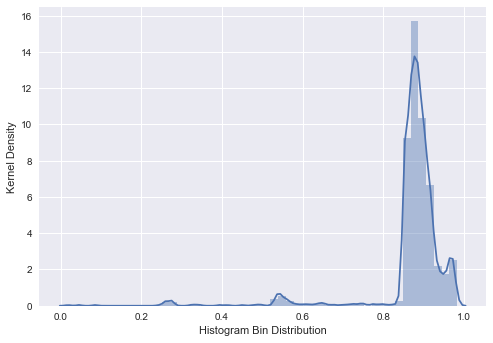

In [236]:
distPlot = sbn.distplot(df['RPM_%'].values, kde=True)
plt.xlabel('Histogram Bin Distribution')
plt.ylabel('Kernel Density')
plt.show()

Plotting


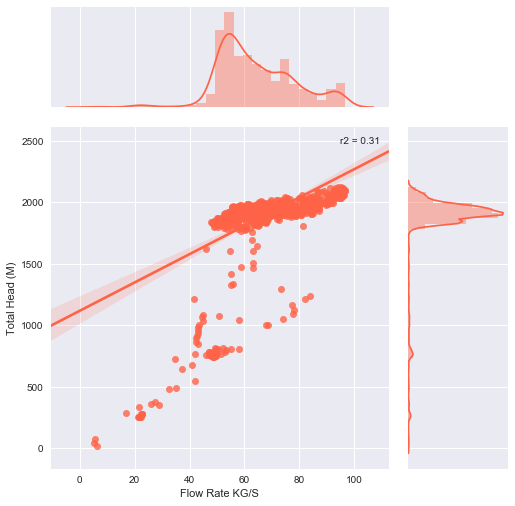

Filter to 90% as per KDE Plot Density


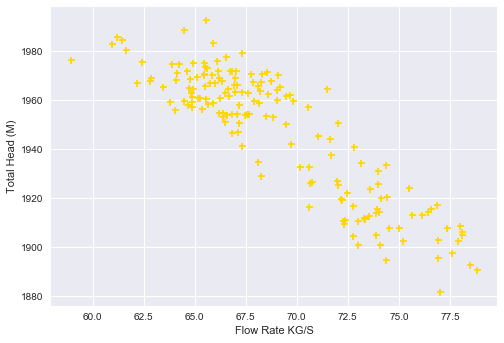

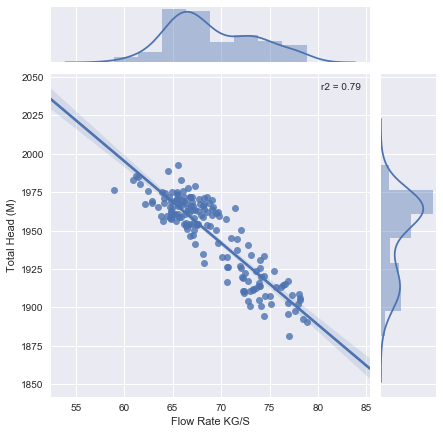

In [237]:
#########################################################################################################
# Further analysis of our dataset reveals Before we apply the 90% Filter to our dataset, it may be worthwhile plotting out the Fl     # 
# should be fitted. The first question we need to address is: Is this valid?                            #
# To address this we want to understand the shape of our data. We have opted to use a KDE plot which    # 
# shows a PDF (X-axis) overlaid with # observations (Y-axis). From this we can see that the majority of #
# observations are at 90%. Hence, it would not make sense for 25%, 50%, 75% or 100% curves to be fitted.#
#########################################################################################################

# Set up the matplotlib figure
#Create Scatter Plot highlighting Total Head vs. Flow Rate
#totalHeadvsFlowRate = df[['Total Head','Flow_Rate_(KG/S)']]
sbn.jointplot(df['Flow_Rate_(KG/S)'].values, df['Total Head'].values, kind="reg", stat_func=r2, size=7, ratio=3, color='tomato')
plt.xlabel('Flow Rate KG/S')
plt.ylabel('Total Head (M)')
print("Plotting")
plt.show()

print("Filter to 90% as per KDE Plot Density")

df2 = df
df2 = df2[(df2['RPM_%']>0.895)& (df2['RPM_%']<0.905)]
plt.scatter(x=df2['Flow_Rate_(KG/S)'].values, y=df2['Total Head'].values, marker='+', color='gold')
plt.xlabel('Flow Rate KG/S')
plt.ylabel('Total Head (M)')
plt.show()

#Now that we have applied the filtering to our scatter plot - let's take another look at the R Squared Value
#Please note that R Squared is by no means an ideal indicator of relationship as it can only increase as
#more variables are added
sbn.jointplot(df2['Flow_Rate_(KG/S)'].values, df2['Total Head'].values, kind="reg", stat_func=r2)
plt.xlabel('Flow Rate KG/S')
plt.ylabel('Total Head (M)')
plt.show()


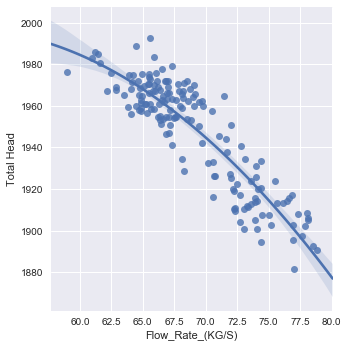

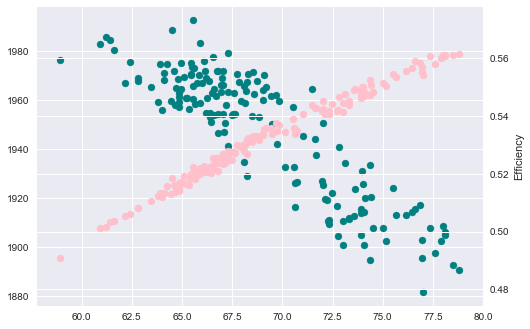

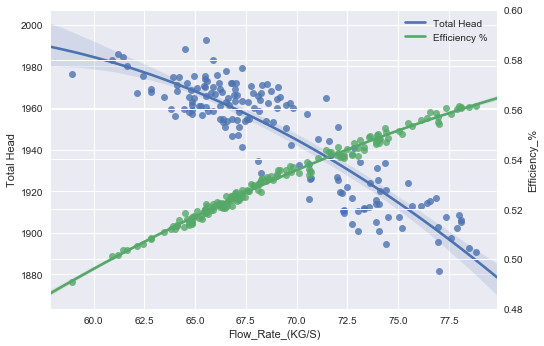

In [238]:
df3 = df2[['Flow_Rate_(KG/S)', 'Total Head']]
df4 = df2[['Flow_Rate_(KG/S)', 'Efficiency_%']]

sbn.lmplot(x="Flow_Rate_(KG/S)", y="Total Head", data=df3, order=2)
plt.show()
fig, ax = plt.subplots()

ax2 = ax.twinx()
ax.scatter(df2['Flow_Rate_(KG/S)'], df2['Total Head'], color='teal')
ax2.scatter(df2['Flow_Rate_(KG/S)'], df2['Efficiency_%'], color='pink')
ax2.set_ylabel('Efficiency')
plt.show()

fig, ax = plt.subplots()

ax2 = ax.twinx()

sbn.regplot(x="Flow_Rate_(KG/S)", y="Total Head", data=df3, order=2, ax=ax)
sbn.regplot(x="Flow_Rate_(KG/S)", y="Efficiency_%", data=df4, order=2, ax=ax2)
ax2.set_ylim([0.48,0.60])
ax2.yaxis.set_major_locator(MultipleLocator(0.02))
ax2.legend(handles=[a.lines[0] for a in [ax,ax2]], labels=["Total Head", "Efficiency %"])
plt.show()





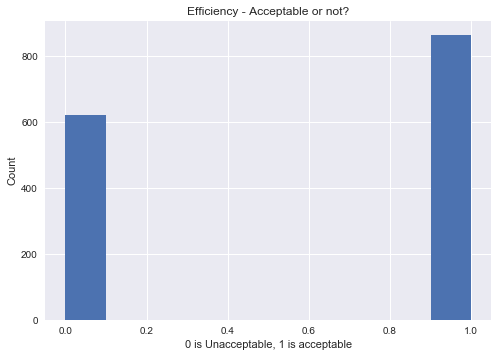

The ratio of acceptable efficiency to unacceptable is: 
0.58 % acceptable efficiency
0.42 % unacceptable efficiency


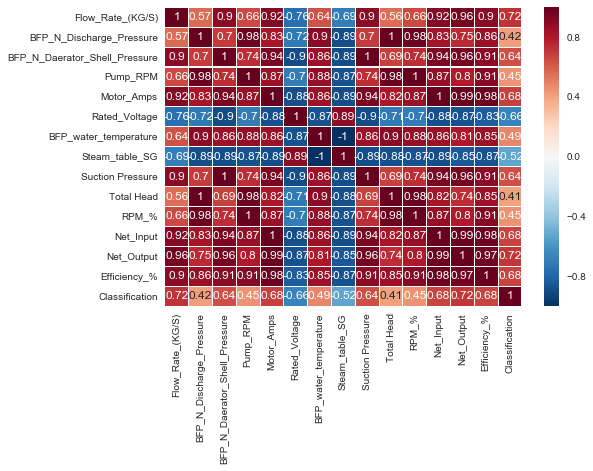

In [272]:
plt.hist(df['Classification'].values, bins=10)
plt.xlabel('0 is Unacceptable, 1 is acceptable')
plt.ylabel('Count')
plt.title('Efficiency - Acceptable or not?')
plt.show()

print ("The ratio of acceptable efficiency to unacceptable is:" + " " + '\n' + str(round(df['Classification'].sum()/len(df['Classification']),2)) + ' % acceptable efficiency')
print ((str(1-(round(df['Classification'].sum()/len(df['Classification']),2))))+ " % unacceptable efficiency")
#We now have a curve which shows the relationship between Total Head and Efficiency.
#In engineering, efficiency is a key metric we are concerned about.
#Taking this into account, we need to understand - what does 'inefficient' efficiency look like?
#The target specifications indicate an efficiency of around 78% is 'good'. Historical data does not support this.
#As such, we will use another measure which will be 'the 'yearly' average.

#We will need to plot out a correlation matrix and exclude the variables which are static. ns denotes non-static. 
df_ns = df
df_ns = df_ns.drop(['Daerator_Height_Conv_Pressure', 'Specific_Gravity', 'Gravity', 'Sulzer_RPM', 'Power_Factor', 'Motor_Efficiency','Gravity_Acceleration'], axis=1)
corr = df_ns.corr()
corr = (corr)
sbn.heatmap(corr, annot=True,linewidths=.1,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()



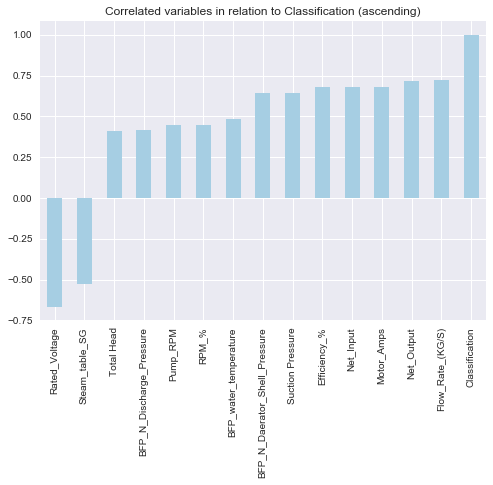

In [322]:
#print (corr['Classification'].head(15))
#print (type(corr['Classification']))
#print (corr['Classification'].sort_values(ascending=True))
#print (corr.row.values)
#corr['Classification'].plot(kind='bar')
#plt.show()
vals = corr['Classification'].sort_values(ascending=True)
corr['Classification'].sort_values(ascending=True).plot(kind='bar', colormap='Paired')
plt.title('Correlated variables in relation to our Classification variable (ascending)')
plt.show()

#pd.plotting.scatter_matrix(df_ns.loc[:, "Flow_Rate_(KG/S)":"Classification"])
#plt.tight_layout()
#plt.show()


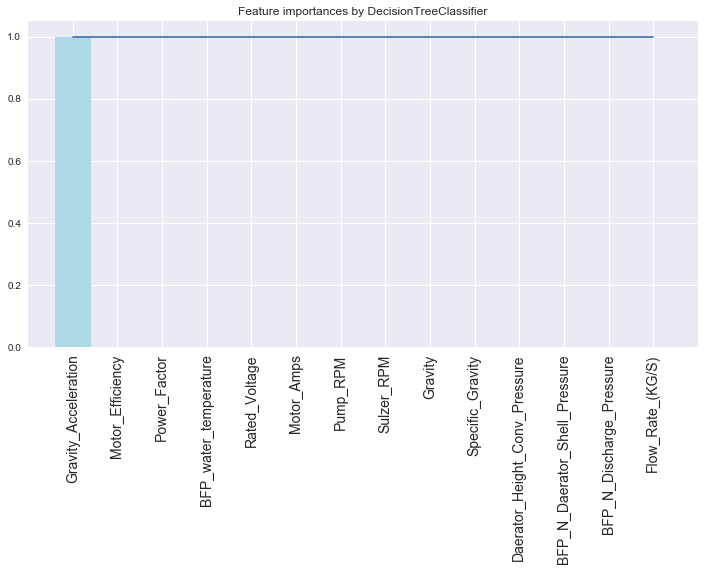

In [316]:
#We now have a model which allows the engineers to visualise 
#The approach to classify whether efficiency is 'good' or 'bad' is:
#Calculate the maximum / minimum values for efficiency - use the average of these values as a baseline measure. If it is within 1
#standard deviation of efficiency, it is acceptable. 
#Otherwise, it is not. 
#Let us try model the variables which impact efficiency
#Most Machine Learning Algorithms are 'distance' based - we will need to scale our variables and see the fit later

#When I come back we need to 1) Scale Data
#After Scaling re-run the tree
#Remove Date Columns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

# Create train and test splits
target_name = 'Classification'
X = df_ns.drop(['Classification'], axis=1)

#Y is our predictor variable. We are aiming to understand what are the variables which impact efficiency.
y= df_ns[target_name]
#We use stratify to maintain our ratio between test/train data points. We have more acceptable (58%) than 'unacceptable' results)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42, stratify=y)

dtree = tree.DecisionTreeClassifier(
    max_depth=10,
    class_weight="balanced",
    min_weight_fraction_leaf=0.1
    )
dtree = dtree.fit(X_train,y_train)

## plot the importances ##
importances = dtree.feature_importances_
feat_names = df.drop(['Classification'],axis=1).columns


indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()





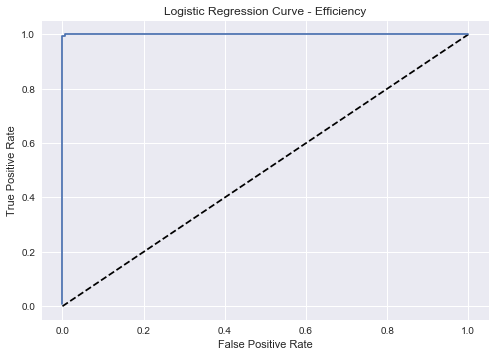

[[152   4]
 [  0 216]]
             precision    recall  f1-score   support

          0       1.00      0.97      0.99       156
          1       0.98      1.00      0.99       216

avg / total       0.99      0.99      0.99       372

logreg score is:0.989247311828
AUC is:0.999970322887
5-fold CV score is:[ 0.99328859  0.97315436  0.96308725  0.98989899  0.98989899]


In [321]:
#Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

X = scale(df_ns.drop(['Classification'], axis=1))
#print (X.shape)
y= df_ns['Classification']
#print (y)
#print (y.shape)
#Instantiate the logreg object
logreg= LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=21, stratify=y)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Logistic Regression on Efficiency')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Curve - Efficiency')
plt.show()

logic_AUC = roc_auc_score(y_test, y_pred_prob)
cv_results = cross_val_score(logreg, X,y, cv=5)
print (confusion_matrix(y_test, y_pred))
print (classification_report(y_test,y_pred))
print ("logreg score is:" + str(logreg.score(X_test,y_test)))
print ("AUC is:" + str(logic_AUC))
print ("5-fold CV score is:" + str(cv_results))



In [325]:
#We will try a KNN model with scaled variables to see if this provides a similar fit
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=6)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=21, stratify=y)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print (knn.score(X_test, y_test))


[1 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1
 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 1
 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 1
 1 1 0 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 0 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 0 1 0
 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 0 1
 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1 0 1 1 0
 0 1 1 0 1 0 0 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1
 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 1 1 1 0 1 0 1 1 0 0 1 1 0 0 0 1 1 1 0 0 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 0 1 1 1
 1 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 1 0 0
 1 0 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 0 0
 1 0 0 0 1 1 1 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1
 1 1 1]
0.986577181208


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices